# Timeseries decomposition, forecasting and outlier detection

Lets start by loading 7 days of CPU measurements for a lab InfluxDB host. Mean values of CPU usage are binned into buckets of 1 minute. Thus resulting in a set of data 1440 points per day. Since the interval is precise and bouned exacty by midnight, then there is no need to maintain timestamps. This results in a vector of following length.

In [2]:
rm(list=ls())
load("/home/jovyan/data/SDM/rdata/cpu-usage-orig.rda")
print(length(timeseries))

[1] 10080


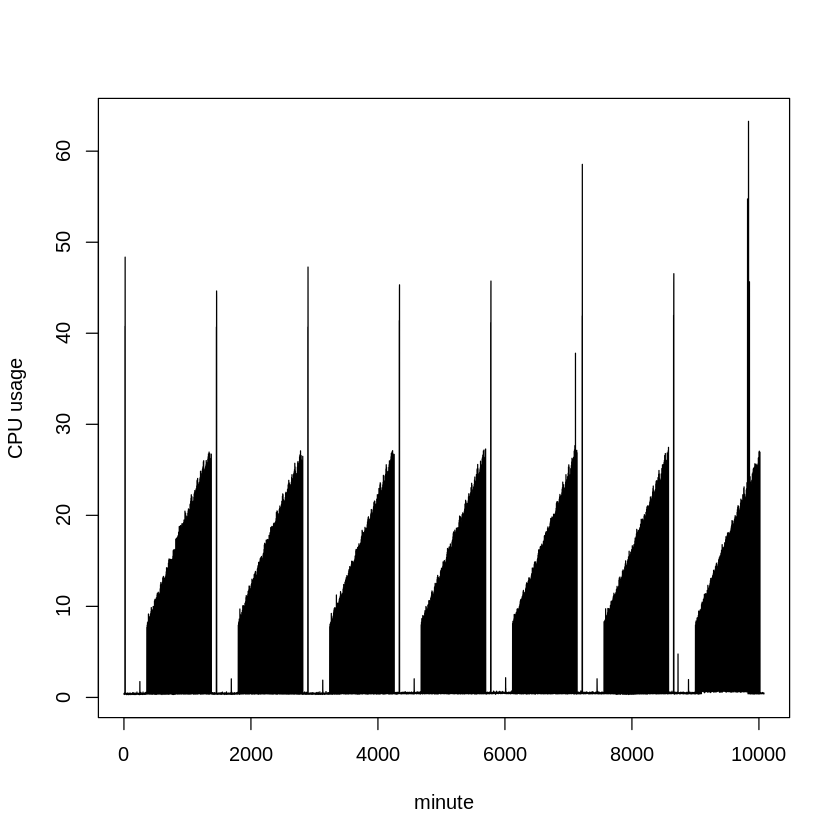

In [3]:
plot(timeseries, type="l", ylab = "CPU usage", xlab = "minute")

There is a clear pattern, but data is quite noisy. We can reduce this noise by binning the data even more, or by smoothing it with a moving average. Former option loses information while the latter introduces delay to real-time anomaly detection. To maintain our resolution of 1440 points per day, I will use the moving average smoothing for now.

In [4]:
ma1 <- function(x, n, sides = 1){
  return(filter(x, rep(1/n,n), sides = sides))
}
timeseries <- ma1(timeseries, n = 15, sides = 1)

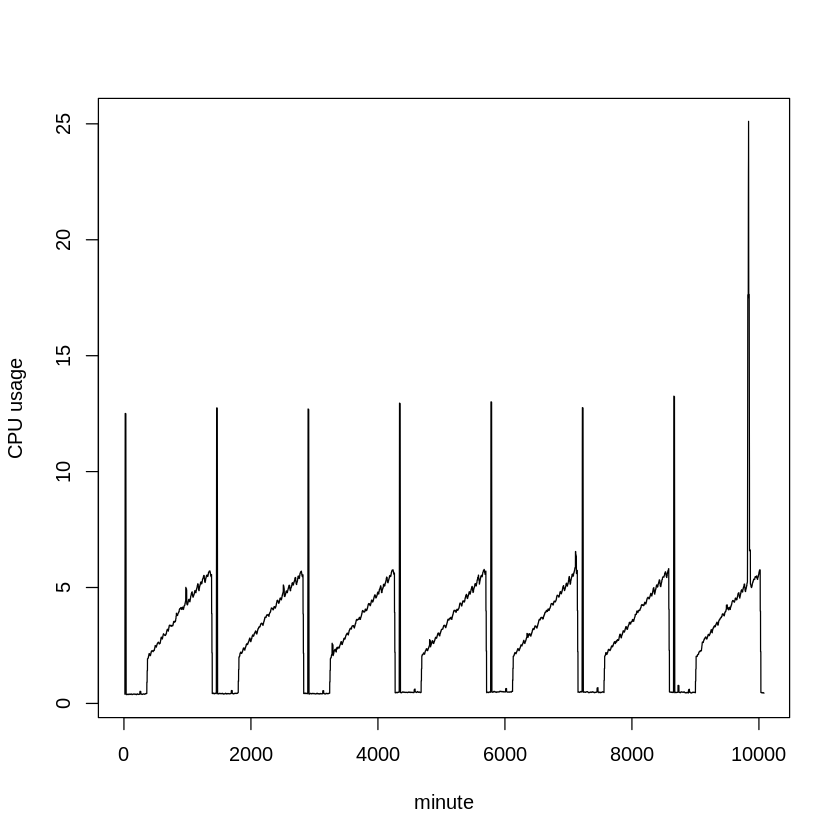

In [5]:
plot(timeseries, type="l", ylab = "CPU usage", xlab = "minute")

Resulting set reduced the amount of noise, while the anomaly on last day is still clearly visible. 

> Note that I used a R filter funciton which applies convolutional filter on timeseries, resulting in a one-sided unweighted moving average. This was done simply to avoid using a for loop. In any reasonable programming language, you can implement something like this (warning! untested out-of-context copypaste code) -

In [6]:
movingAverage <- function(){
    ma1 <- c(rep(NA,4))
    items <- 4
    for( i in seq_along(1:(length(x)-items))){
        set <- x[i:((i-1)+items)]
        ma1[i+items] <- mean(set)
    }
    return(ma1)
}

Autoregressive Moving Average (ARMA) models are commonly used to forecast future timeseries points when historical data with clear seasonal patterns is available. For outlier detection, the idea is to predict past periods and compare these predictions against actual values. This creates an anomaly score for each data point and an alarm can be raised if this score exceeds a certain threshold. Currently, we are only concerned about a single example series, but PCA trick can be used to potentially scale this method to thousands of parallel series.

Firstly, we will separate validation data that will be forecasted from prior training data. For this example, last day will be separated.

In [7]:
total <- length(timeseries)
cycle <- 1440
train <- timeseries[c(1:(total - cycle))]

# our training data seemed to have missing values, just pad with zero for now
train[is.na(train)] <- 0

validate <- timeseries[c( (total-cycle):total )]
# drop last excessive timestamp
validate <- validate[-1441]

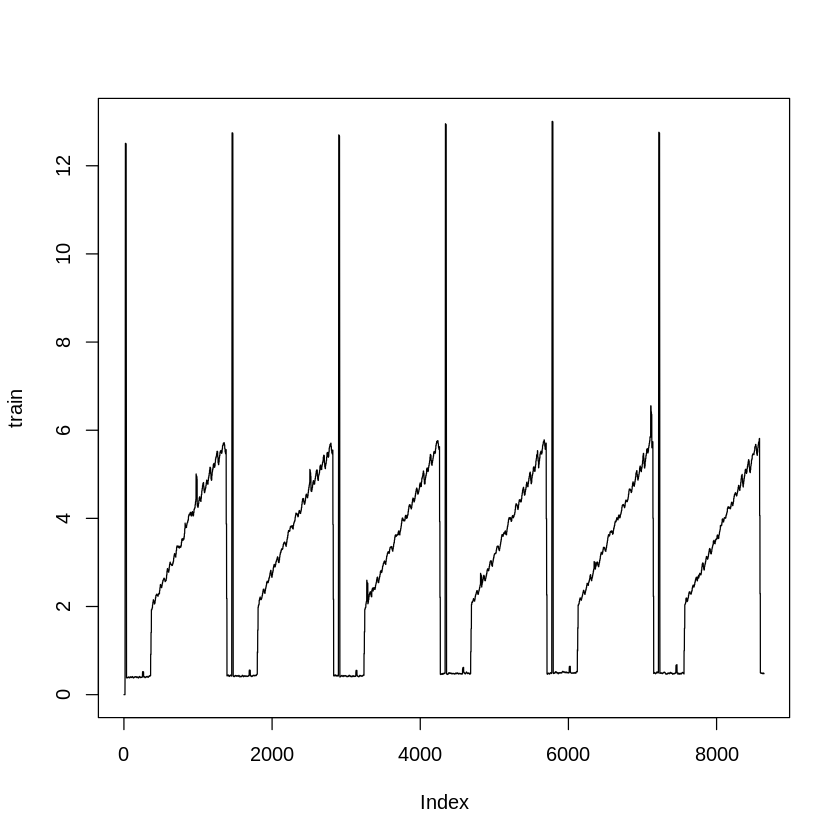

In [8]:
plot(train, type = "l")

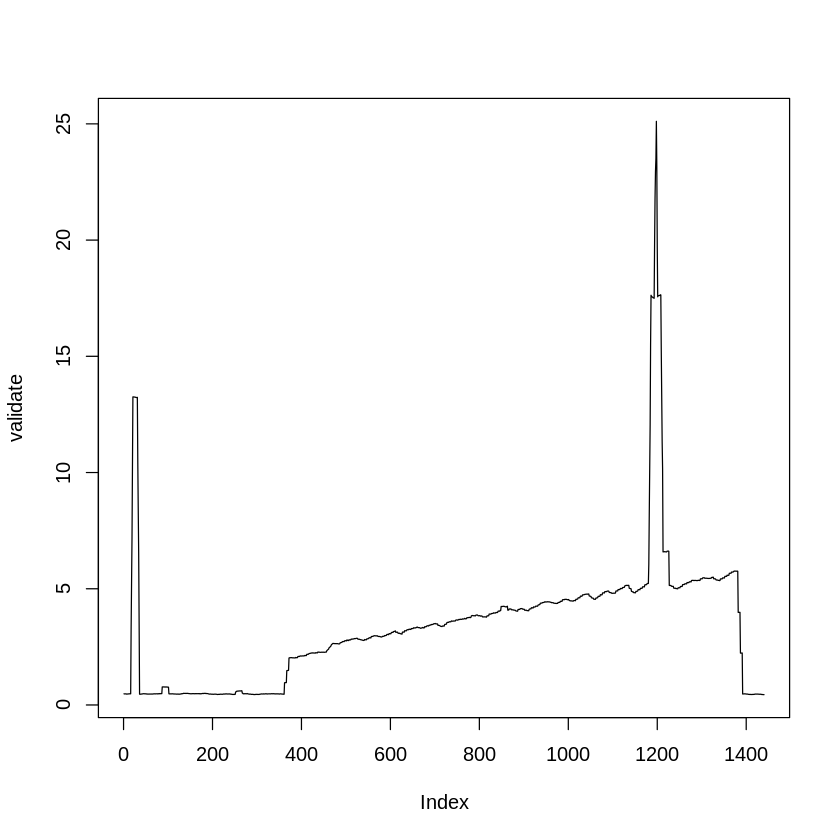

In [9]:
plot(validate, type = "l")

Notice that spike at the beginning of the day is acually not an anomaly when looked at from weekly context. However, the spike at the end of the day is strange and would warrant further inspection.

We have to decompose this series by removing cyclic trend, seasonal pattern and random elements. Additive or multiplicative models can be used depending on the nature of data. Multiplicative can be better when cyclic increase or decrease can be observed while being unsuitable for use on mean-centered normalized data. We will use additive model for this exercise, as no exponential cyclic increase or decrease can be observed.

Cyclic trend can be extracted by calculating weighted moving average.

In [10]:
#trendpatterns <- apply(Ptrunc, 2, ma2, n = SEASONS, slide=TRUE)
ma2 <- function(x, n = 60, slide = TRUE){
  # we do weigted moving average, as opposed to 2-ma of N-ma
  if (slide == TRUE){
    partial <- 1/(n*2)
    filter <- c(partial, rep(1/n, n-1), partial)
  } else {
    filter <- c(rep(1/n, n))
  }
  return(filter(x, filter = filter, sides=2))
}
trend <- ma2(train, n = 1440, slide = TRUE)

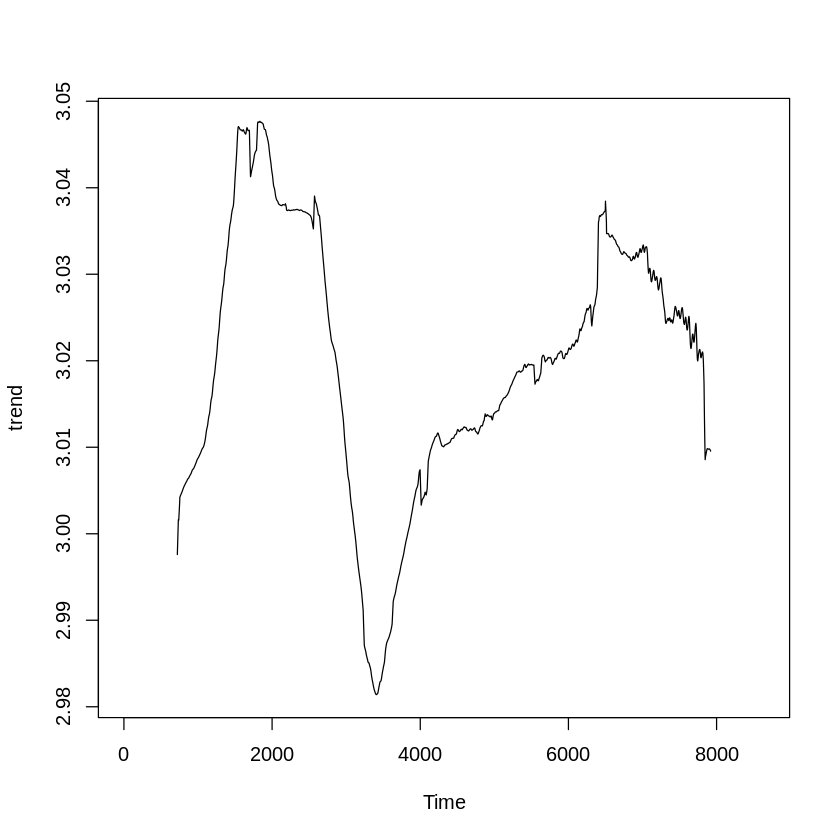

In [11]:
plot(trend, type = "l")

Then we will need to remove trend from series and calculate seasonal coefficients.

In [12]:
noTrend <- train - trend

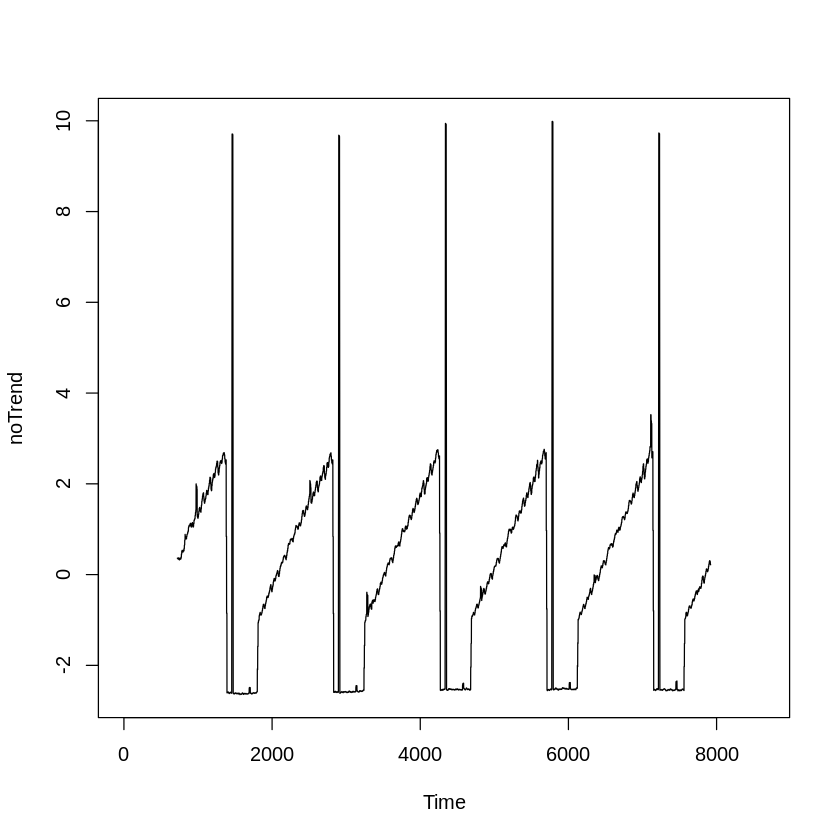

In [13]:
plot(noTrend, type = "l")

Seasonal indices can simply be calcuating by measuring the average value for every season over available training cycles.

In [14]:
seasonalIndex <- function(x, cycles, seasons){
  x <- matrix(x, nrow = seasons, ncol = cycles)
  x[,1] <- ifelse(is.na(x[,1]), x[,ncol(x)], x[,1])
  x <- x[,-ncol(x)]
  x <- rowMeans(x)
  return(x)
}

Consider this simplified example of quarterly data over a period of 4 years. We will derive trend via weighted moving average over 4 quarters per year which will then be multiplicatively removed from original data. This leaves us with only seasonal component.

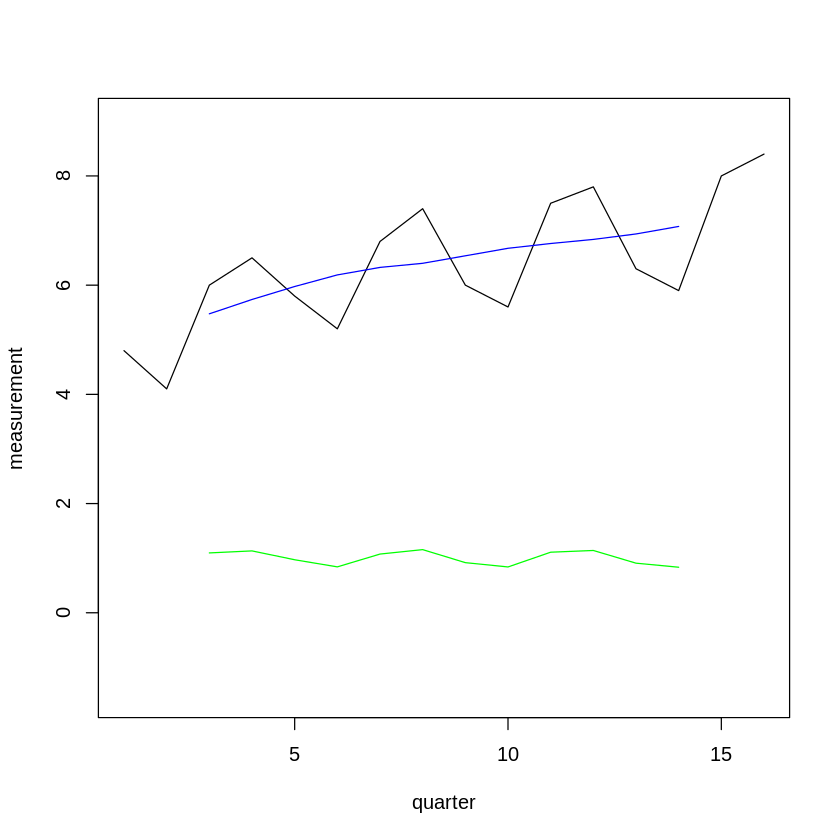

In [15]:
x <- c(4.8, 4.1, 6.0, 6.5, 5.8, 5.2, 6.8, 7.4, 6.0, 5.6, 7.5, 7.8, 6.3, 5.9, 8.0, 8.4)
x_trend <- ma2(x, 4, TRUE)
sc <- x / x_trend

plot(x, type = "l", xlab = "quarter", ylab = "measurement", ylim = c(-1.5, 9))
lines(x_trend, col = "blue")
lines(sc, col = "green")

In [16]:
sc <- matrix(sc, ncol=4, nrow=4)
sc

NA,0.9707113,0.9177820,0.9081081
NA,0.8404040,0.8389513,0.8339223
1.095890,1.0750988,1.1090573,NA
1.132898,1.1562500,1.1407678,NA


In [17]:
sc[,1] <- ifelse(is.na(sc[,1]), sc[,ncol(sc)], sc[,1])
sc <- sc[,-4]
sc

0.9081081,0.9707113,0.9177820
0.8339223,0.8404040,0.8389513
1.0958904,1.0750988,1.1090573
1.1328976,1.1562500,1.1407678


Centered moving average loses data from the edges, so we are now missing 1 cycle worth of data. However, since trend is already removed, we can simply fill the gaps in first cycle with data from final one. After that, the final cycle can be discarded. And we can calculate mean values for each row to get final seasonal compoinent.

In [18]:
sc <- rowMeans(sc)
sc

[1] 0.9322005 0.8377592 1.0933488 1.1433051

`seasonalIndex` function does this in a nutshell. We can now do the same for our CPU usage data.

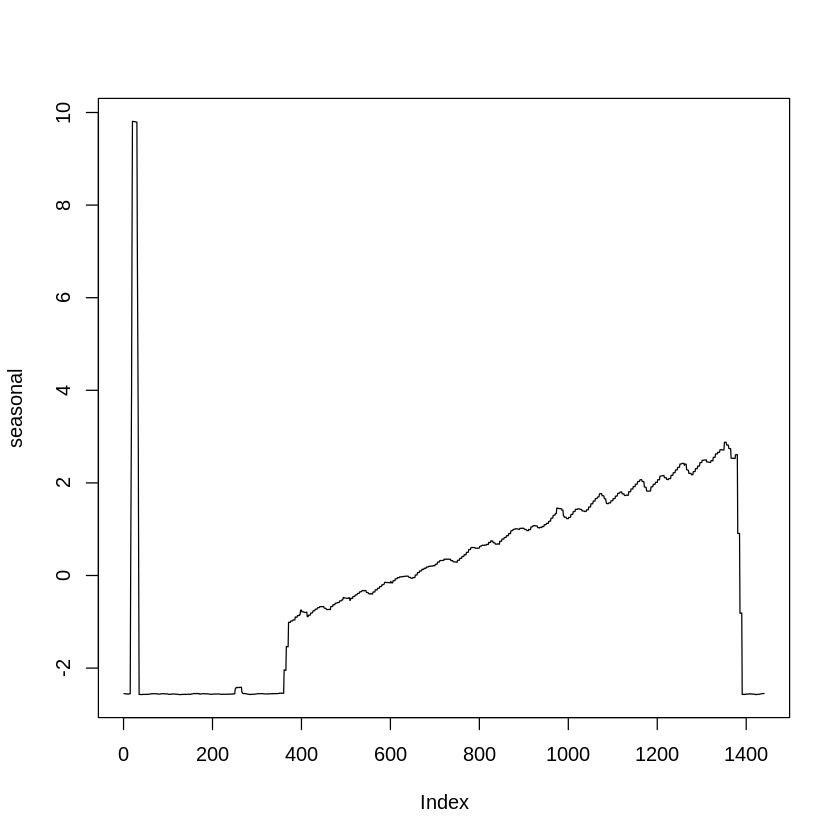

In [19]:
seasonal <- seasonalIndex(noTrend, 6, 1440)
plot(seasonal, type = "l")

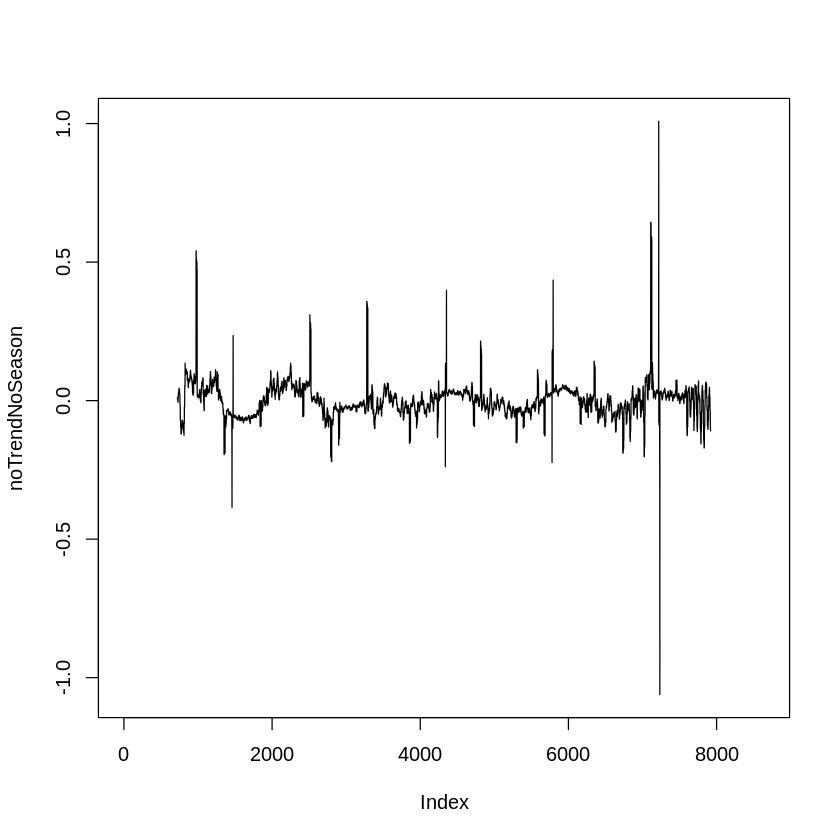

In [20]:
noTrendNoSeason <- matrix(noTrend, nrow=1440, ncol = 6) - seasonal
noTrendNoSeason <- as.vector(noTrendNoSeason)
plot(noTrendNoSeason, type = "l")

We are now done with simple additive decomposition of our CPU measurement data. Next up, we will use simple linear regression to plot optimal path through decomposed data.

In [21]:
regression <- function(x){
  return(lm(as.vector(x)~c(1:length(x))))
}

In [38]:
#slr <- regression(noTrendNoSeason)
#slr

adjusted <- matrix(train, nrow = 1440, ncol = 6) - seasonal
#y <- as.vector(adjusted)
#x <- c(1:length(y))

slr <- regression(adjusted)
slr

y <- as.vector(adjusted)
x <- c(1:length(y))

slope <- cor(x, y)* (sd(y)/sd(x))
intercept <- mean(y) - (slope * mean(x))
# y = slope * x + intercept
print(c(intercept, slope))


Call:
lm(formula = as.vector(x) ~ c(1:length(x)))

Coefficients:
   (Intercept)  c(1:length(x))  
     3.003e+00       1.980e-06  


[1] 3.002550e+00 1.979572e-06


In [40]:
#y = slope * x + intercept

Resulting regression cefficients allow us to predict future trends. We have to define bin indexes that correspond to timestamps ourselves. In our case, we want to predict one full day which has 1440 minutes.

In [34]:
predictTrends <- function(lr,t = c(1,2,3)){
  return(t*lr$coefficients[2]+lr$coefficients[1])
}

In [42]:
future_idx <- seq(length(adjusted)+1,length(adjusted)+1440,1)
head(future_idx)
tail(future_idx)

[1] 8641 8642 8643 8644 8645 8646

[1] 10075 10076 10077 10078 10079 10080

In [50]:
#future <- predictTrends(slr, future_idx)
future <- slope * future_idx + intercept
future <- future + seasonal
#future

We are not actually concerned about the future forecasting. Instad, we would like to compare our predictions against actual data points to raise alerts on deviations.

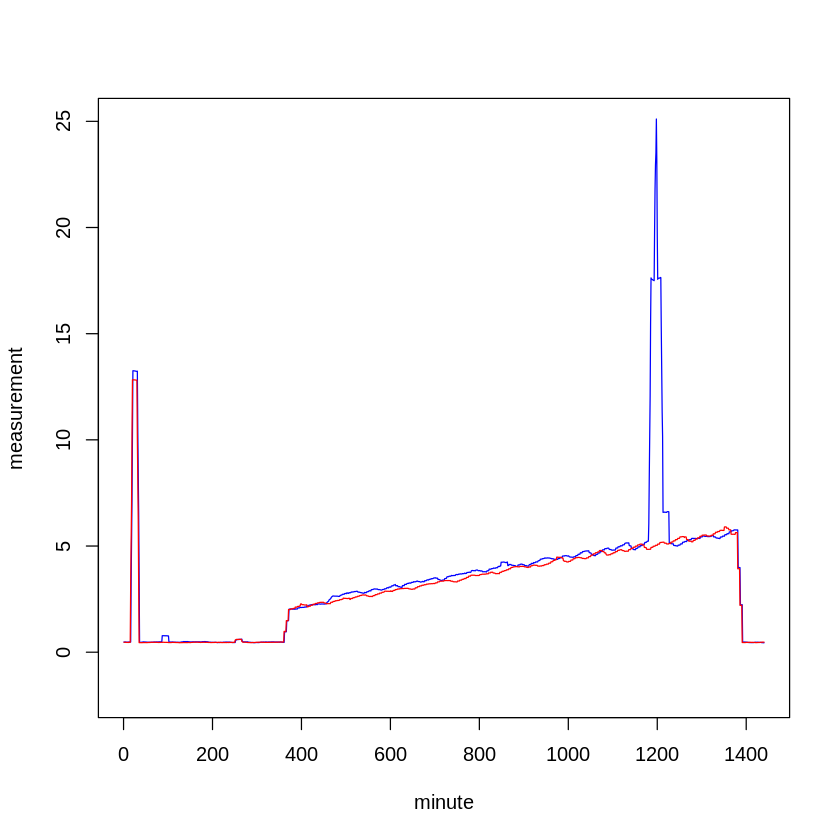

In [52]:
plot(validate, type = "l", xlab = "minute", ylab = "measurement", col = "blue", ylim = c(-2, 25))
lines(future, type = "l", col = "red")

In [53]:
deviations <- future - validate

Simple method for creating unified outlier scores for each data point is to normalize deviations via regular data standardization method.

$$ \frac{\delta_i - \mu}{\sigma} $$

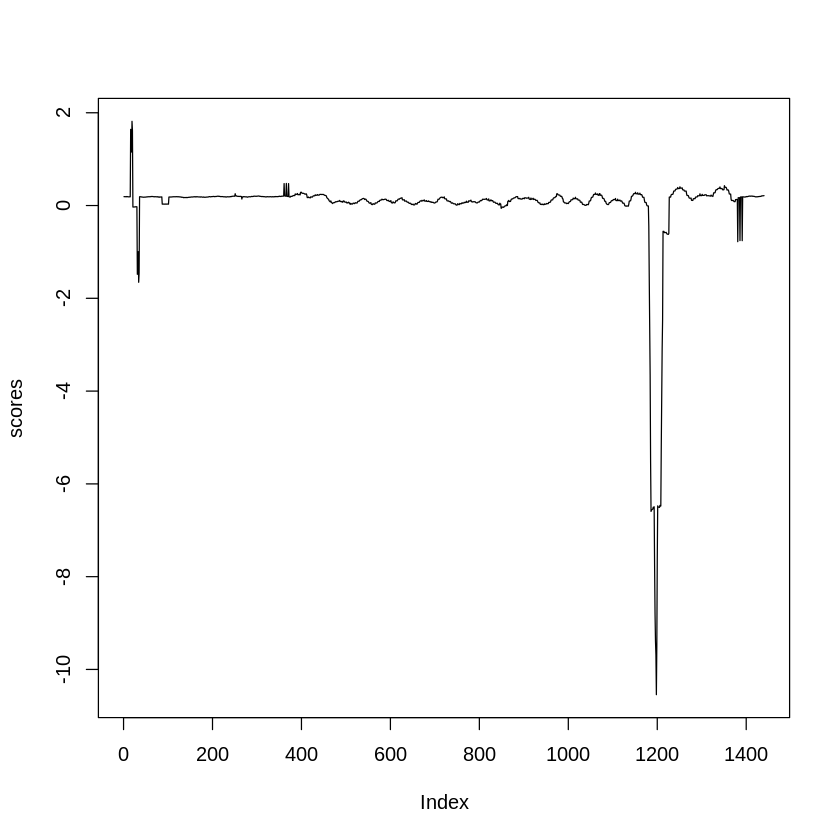

In [54]:
scores <- (deviations - mean(deviations)) / sd(deviations)
plot(scores, type = "l")

Outlier scores represent number of standard deviations the value is away from mean, or sigma. Anomaly score of 3 is considered statistically sufficient to raise an alarm, as most 99 percent of values should fall within 3 standard deviations from mean.

* https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule

In practice, though, higher values may need to be used if timeseries displays weak seasonal patterns or is noisy.

In [55]:
alertLevel <- function(x, thresh = 3){
  return(which(x > thresh))
}

In [56]:
alerts <- alertLevel(abs(scores), thresh = 3)

In [57]:
ymin <- min(train, future, validate)
ymax <- max(train, future, validate)

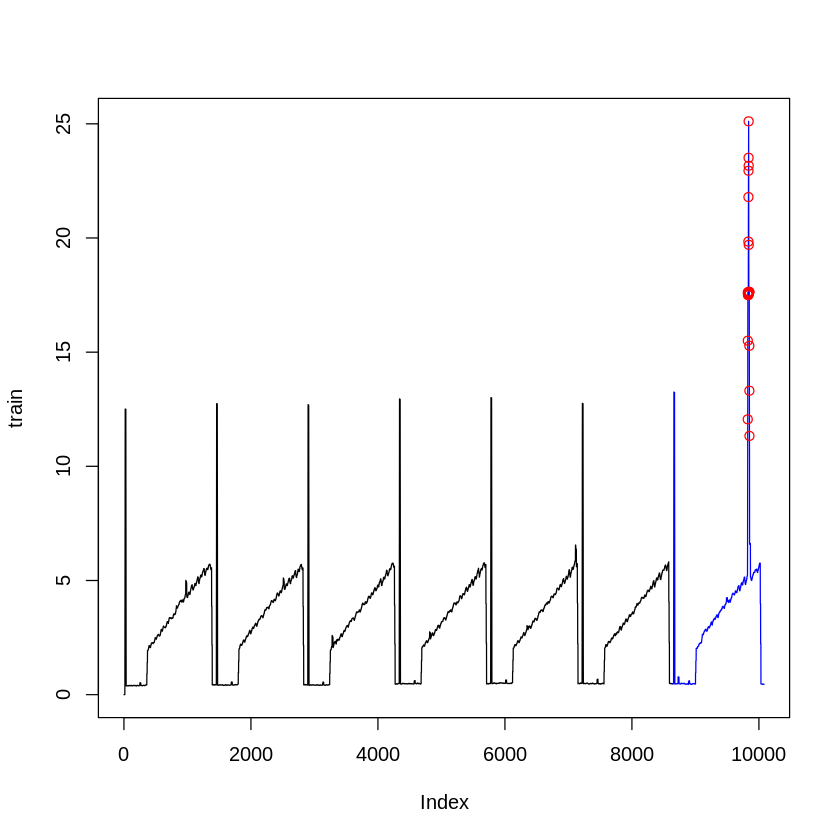

In [58]:
plot(train, type="l", xlim = c(1,7*1440), ylim = c(ymin, ymax))
lines(c(rep(NA, length(train)), validate), col = "blue")

outliers <- rep(NA, length(validate))
outliers[alerts] <- validate[alerts]
outliers <- c(rep(NA, length(train)), outliers)

#alerts
points(outliers, col = "red")